# 画像濃度のbaselineモデル（PLS）を構築

## ライブラリをインポート

In [32]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text
from pandas import json_normalize
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

## グラフ表示の際のフォント種類やフォントサイズを設定

In [33]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["font.family"] = "IPAexGothic"  #'Times New Roman'

## ファイルのコンフィグ情報を定義

In [34]:
class CFG:
    input_dir = "../input"
    output_dir = "../output"
    random_seed = 42
    exp_no = "exp000"
    target = "画像濃度"

## データを読み込み、データフレームに格納

In [35]:
train_df = pd.read_csv(f"{CFG.input_dir}/chapter2_demo_data_postprocess.csv")
train_df

,サンプルID,サンプル名,サンプル作成日,担当者,備考,溶媒１,溶媒2,溶媒3,添加剤1,添加剤2,...,乾燥温度,乾燥時間,擦過回数,擦過圧力,耐擦過性(n10,画像濃度,粘度,表面張力,保存後粘度,保存後状態
0,DP_001,界1_2.0,2024/1/19,高岡,界面活性剤1水準振り,46.9,40,0,2,0,...,25,NaN,10,5,2.4,1.06,9.0,35,NaN,NaN
1,DP_002,界1_1.5,2024/1/19,高岡,界面活性剤1水準振り,47.4,40,0,2,0,...,25,NaN,10,5,2.4,1.07,9.0,38,NaN,NaN
2,DP_003,界1_1.2,2024/1/19,高岡,界面活性剤1水準振り,47.7,40,0,2,0,...,25,NaN,10,5,2.4,1.07,9.0,40,NaN,NaN
3,DP_004,界1_1.0,2024/1/19,高岡,界面活性剤1水準振り,47.9,40,0,2,0,...,25,NaN,10,5,2.4,1.08,9.0,41,NaN,NaN
4,DP_005,界1_0.5,2024/1/19,高岡,界面活性剤1水準振り,48.4,40,0,2,0,...,25,NaN,10,5,2.4,1.09,9.0,44,NaN,NaN
5,DP_006,界1_1.5_樹1_4.0_ref,2024/1/30,福原,ref,47.4,40,0,2,0,...,25,NaN,10,5,2.7,1.07,9.1,38,NaN,NaN
6,DP_007,界2_1.5_樹1_4.0,2024/1/30,福原,界面活性剤1種類検討,47.4,40,0,2,0,...,25,NaN,10,5,2.7,1.05,9.1,37,NaN,NaN
7,DP_008,界3_1.5_樹1_4.0,2024/1/30,福原,界面活性剤1種類検討,47.4,40,0,2,0,...,25,NaN,10,5,2.7,1.02,9.1,39,NaN,NaN
8,DP_009,界1_1.5_樹1_6.0,2024/1/30,福原,定着樹脂１水準振り,45.4,40,0,2,0,...,25,NaN,10,5,3.1,1.07,10.3,36,NaN,NaN
9,DP_010,界1_1.5_樹1_8.0,2024/1/30,福原,定着樹脂１水準振り,43.4,40,0,2,0,...,25,NaN,10,5,3.6,1.07,11.5,34,NaN,NaN


## referenceサンプルをデータから削除する

In [36]:
# 備考にrefと書かれているデータを削除
train_df = train_df[train_df["備考"] != "ref"]
# インデックスを振り直す
train_df = train_df.reset_index(drop=True)
train_df

,サンプルID,サンプル名,サンプル作成日,担当者,備考,溶媒１,溶媒2,溶媒3,添加剤1,添加剤2,...,乾燥温度,乾燥時間,擦過回数,擦過圧力,耐擦過性(n10,画像濃度,粘度,表面張力,保存後粘度,保存後状態
0,DP_001,界1_2.0,2024/1/19,高岡,界面活性剤1水準振り,46.9,40,0,2,0,...,25,NaN,10,5,2.4,1.06,9.0,35,NaN,NaN
1,DP_002,界1_1.5,2024/1/19,高岡,界面活性剤1水準振り,47.4,40,0,2,0,...,25,NaN,10,5,2.4,1.07,9.0,38,NaN,NaN
2,DP_003,界1_1.2,2024/1/19,高岡,界面活性剤1水準振り,47.7,40,0,2,0,...,25,NaN,10,5,2.4,1.07,9.0,40,NaN,NaN
3,DP_004,界1_1.0,2024/1/19,高岡,界面活性剤1水準振り,47.9,40,0,2,0,...,25,NaN,10,5,2.4,1.08,9.0,41,NaN,NaN
4,DP_005,界1_0.5,2024/1/19,高岡,界面活性剤1水準振り,48.4,40,0,2,0,...,25,NaN,10,5,2.4,1.09,9.0,44,NaN,NaN
5,DP_007,界2_1.5_樹1_4.0,2024/1/30,福原,界面活性剤1種類検討,47.4,40,0,2,0,...,25,NaN,10,5,2.7,1.05,9.1,37,NaN,NaN
6,DP_008,界3_1.5_樹1_4.0,2024/1/30,福原,界面活性剤1種類検討,47.4,40,0,2,0,...,25,NaN,10,5,2.7,1.02,9.1,39,NaN,NaN
7,DP_009,界1_1.5_樹1_6.0,2024/1/30,福原,定着樹脂１水準振り,45.4,40,0,2,0,...,25,NaN,10,5,3.1,1.07,10.3,36,NaN,NaN
8,DP_010,界1_1.5_樹1_8.0,2024/1/30,福原,定着樹脂１水準振り,43.4,40,0,2,0,...,25,NaN,10,5,3.6,1.07,11.5,34,NaN,NaN
9,DP_011,界1_1.5_樹1_10.0,2024/1/30,福原,定着樹脂１水準振り,41.4,40,0,2,0,...,25,NaN,10,5,4.0,1.07,12.7,32,NaN,NaN


## データの列名を確認

In [37]:
# train_dfの列名をリストで取得
columns = train_df.columns
# train_dfの列名を表示
columns

Index(['サンプルID', 'サンプル名', 'サンプル作成日', '担当者', '備考', '溶媒１', '溶媒2', '溶媒3', '添加剤1',
       '添加剤2', '界面活性剤１', '界面活性剤２', '界面活性剤３', '顔料１', '顔料２', '定着樹脂１', '定着樹脂２',
       '防腐剤', '塗布量', '乾燥方式', '乾燥温度', '乾燥時間', '擦過回数', '擦過圧力', '耐擦過性(n10',
       '画像濃度', '粘度', '表面張力', '保存後粘度', '保存後状態'],
      dtype='object')

## データの欠損を確認

In [38]:
# 欠損のある列を表示
train_df.isnull().sum()

サンプルID       0
サンプル名        0
サンプル作成日      0
担当者          0
備考           0
溶媒１          0
溶媒2          0
溶媒3          0
添加剤1         0
添加剤2         0
界面活性剤１       0
界面活性剤２       0
界面活性剤３       0
顔料１          0
顔料２          0
定着樹脂１        0
定着樹脂２        0
防腐剤          0
塗布量          0
乾燥方式         0
乾燥温度         0
乾燥時間        13
擦過回数         0
擦過圧力         0
耐擦過性(n10     0
画像濃度         0
粘度           0
表面張力         0
保存後粘度       24
保存後状態       24
dtype: int64

## 使用する説明変数をリストとして定義

In [39]:
numeric_parameter_cols = [
    # 'サンプルID', 'サンプル名', 'サンプル作成日', '担当者', '備考',
    "溶媒１",
    "溶媒2",
    "溶媒3",
    "添加剤1",
    "添加剤2",
    "界面活性剤１",
    "界面活性剤２",
    "界面活性剤３",
    "顔料１",
    "顔料２",
    "定着樹脂１",
    "定着樹脂２",
    "防腐剤",
    "塗布量",
    "乾燥方式",
    "乾燥温度",
    # '乾燥時間',
    # "擦過回数",
    # "擦過圧力",
    # '耐擦過性(n10','画像濃度', '粘度', '表面張力', '保存後粘度'
]

## 説明変数と目的変数の定義

In [40]:
train_X = train_df[numeric_parameter_cols]
objective_cols = [CFG.target]
train_Y = train_df[objective_cols]

## PLSRegressionを用いたLeave-one-outによる交差検証

0it [00:00, ?it/s]

/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


Int64Index([0], dtype='int64')
RMSE_train: 0.09468496007186192
MAE_train: 0.06848368834812289
R2_train: 0.7095755111757437


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([1], dtype='int64')
RMSE_train: 0.09433106879825315
MAE_train: 0.06813849531041077
R2_train: 0.7122987303773705


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([2], dtype='int64')
RMSE_train: 0.09421419535911717
MAE_train: 0.06808367161725427
R2_train: 0.7130111956824114
Int64Index([3], dtype='int64')
RMSE_train: 0.09401170866527915
MAE_train: 0.06774194282418577
R2_train: 0.7147282216128188


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([4], dtype='int64')
RMSE_train: 0.09363952065138167
MAE_train: 0.06719962264358516
R2_train: 0.7173968293158884
Int64Index([5], dtype='int64')
RMSE_train: 0.09386957839245189
MAE_train: 0.06740794013903809
R2_train: 0.7139367069788851


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([6], dtype='int64')
RMSE_train: 0.09401339359943785
MAE_train: 0.06729216551111293
R2_train: 0.7107751713558679
Int64Index([7], dtype='int64')
RMSE_train: 0.09461150535018081
MAE_train: 0.06866620194277674
R2_train: 0.7105855751542957


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([8], dtype='int64')
RMSE_train: 0.09463036824093392
MAE_train: 0.06876757108361564
R2_train: 0.7104701613499538
Int64Index([9], dtype='int64')
RMSE_train: 0.09435289543705087
MAE_train: 0.06774480091770724
R2_train: 0.7121655764066677


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([10], dtype='int64')
RMSE_train: 0.09434640799191227
MAE_train: 0.06897886413832038
R2_train: 0.7122051564498209


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([11], dtype='int64')
RMSE_train: 0.0944779198855181
MAE_train: 0.0679207390837976
R2_train: 0.7114022679326306
Int64Index([12], dtype='int64')
RMSE_train: 0.09382896781477428
MAE_train: 0.0675903805669675
R2_train: 0.7153533049279399


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([13], dtype='int64')
RMSE_train: 0.09326524556731648
MAE_train: 0.0666535307674112
R2_train: 0.7187633317758566


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([14], dtype='int64')
RMSE_train: 0.09326524556731648
MAE_train: 0.0666535307674112
R2_train: 0.7187633317758566
Int64Index([15], dtype='int64')
RMSE_train: 0.09345116508204564
MAE_train: 0.06697804115017088
R2_train: 0.7176409522510799


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([16], dtype='int64')
RMSE_train: 0.09311859150608683
MAE_train: 0.06635363586065197
R2_train: 0.7196470923245519
Int64Index([17], dtype='int64')
RMSE_train: 0.09216248165529649
MAE_train: 0.06596013378201507
R2_train: 0.7253746717243336


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([18], dtype='int64')
RMSE_train: 0.09274356421603239
MAE_train: 0.06586678182502839
R2_train: 0.7200864039640487
Int64Index([19], dtype='int64')
RMSE_train: 0.09383394074010414
MAE_train: 0.06810372900966712
R2_train: 0.7162220951459192


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/var/folders/3q/gwgy4r2561v6xx__yjlk15b80000gn/T/ipykernel_5443/3316188719.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 8))


Int64Index([20], dtype='int64')
RMSE_train: 0.09312556567860159
MAE_train: 0.06715671760897984
R2_train: 0.7204905381098585


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([21], dtype='int64')
RMSE_train: 0.09059317613719196
MAE_train: 0.06754984414794565
R2_train: 0.7354854058754559
Int64Index([22], dtype='int64')
RMSE_train: 0.08606344930334085
MAE_train: 0.06438010387413405
R2_train: 0.7612759561912594


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([23], dtype='int64')
RMSE_train: 0.09588721450931782
MAE_train: 0.06926137036737338
R2_train: 0.7036669630622854
Int64Index([24], dtype='int64')
RMSE_train: 0.09333855799355747
MAE_train: 0.06390813336899676
R2_train: 0.7080790846815648


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([25], dtype='int64')
RMSE_train: 0.0853332518348403
MAE_train: 0.05348488990483512
R2_train: 0.7133646892776194


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([26], dtype='int64')
RMSE_train: 0.0918859475562455
MAE_train: 0.0624510952520355
R2_train: 0.7288134463691517


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([27], dtype='int64')
RMSE_train: 0.08554038778828699
MAE_train: 0.06315794217353685
R2_train: 0.7416852136190757
Int64Index([28], dtype='int64')
RMSE_train: 0.07343732616316873
MAE_train: 0.0584820951912261
R2_train: 0.7528743012101256


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([29], dtype='int64')
RMSE_train: 0.08951849198642303
MAE_train: 0.058635879657517924
R2_train: 0.6598356415376847


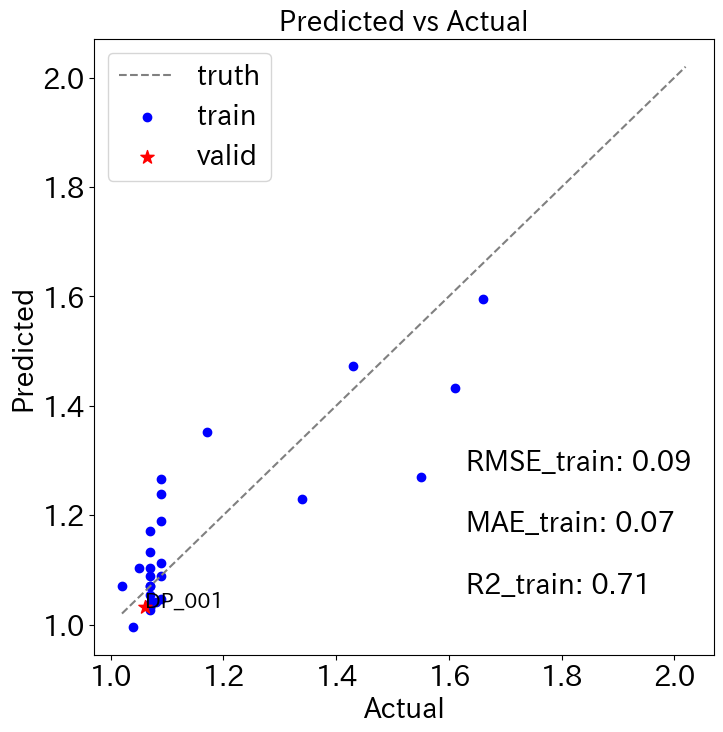

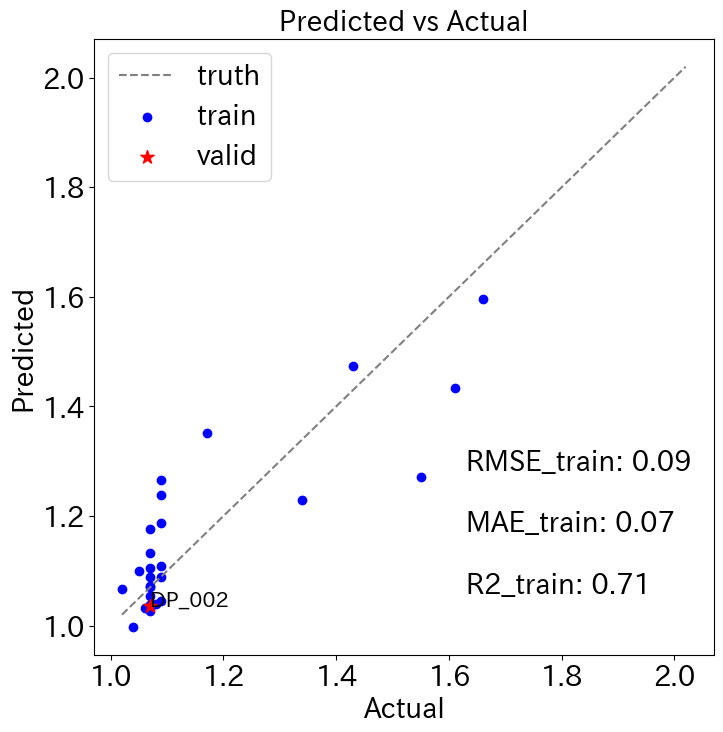

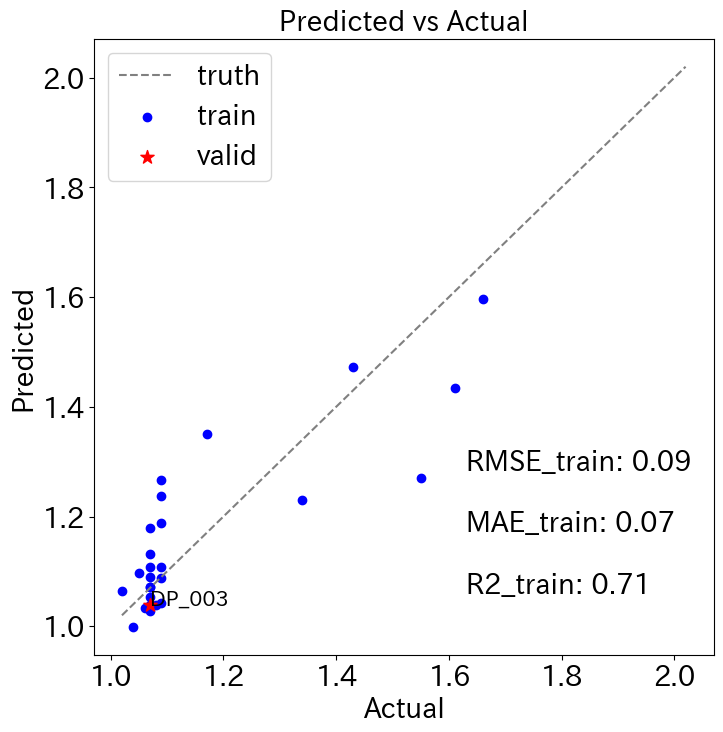

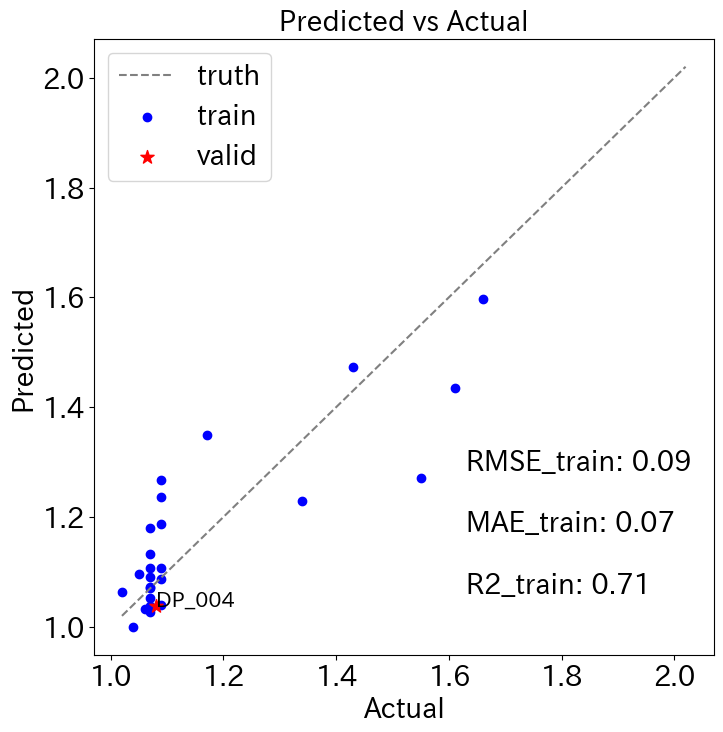

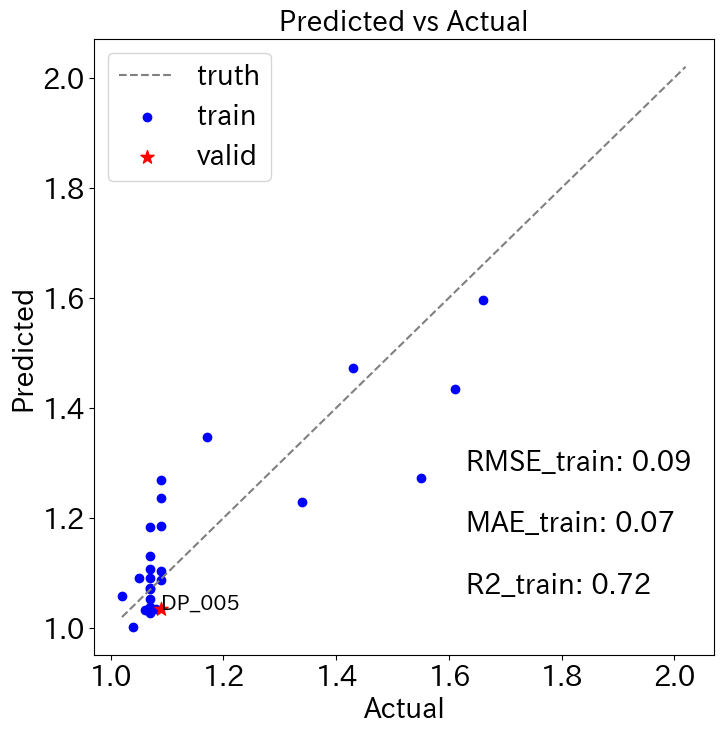

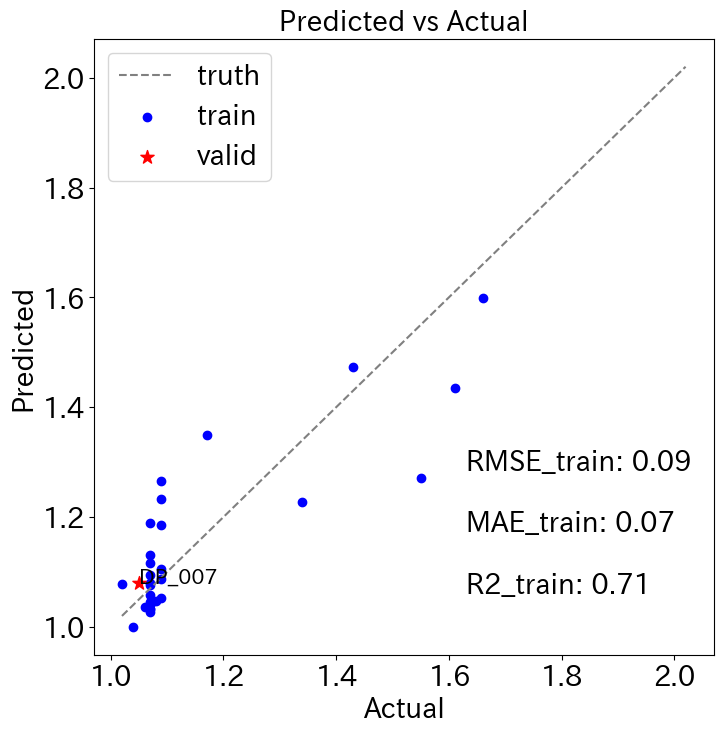

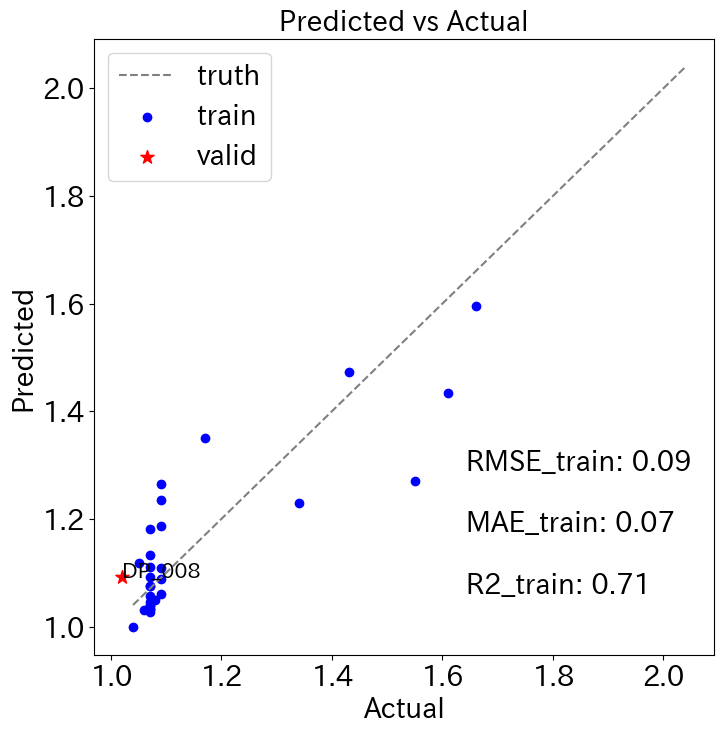

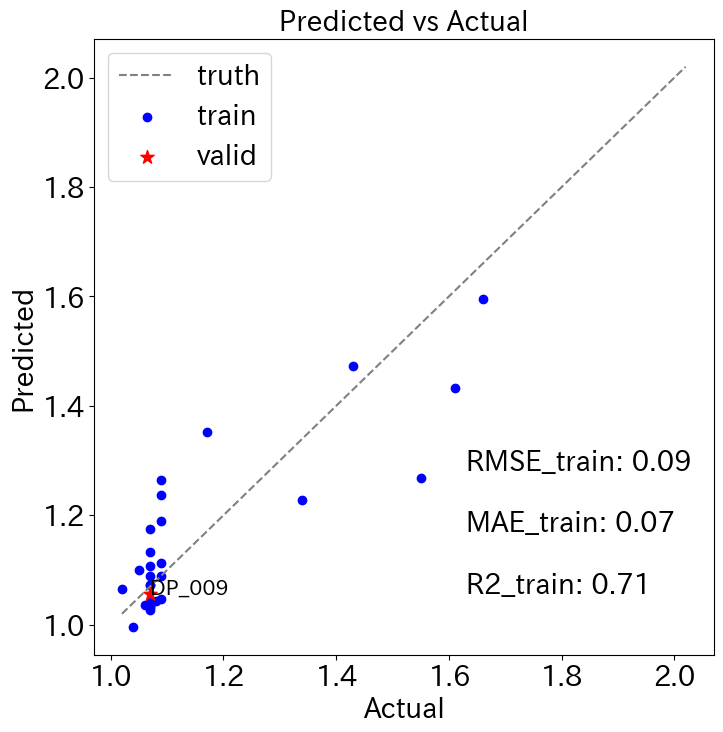

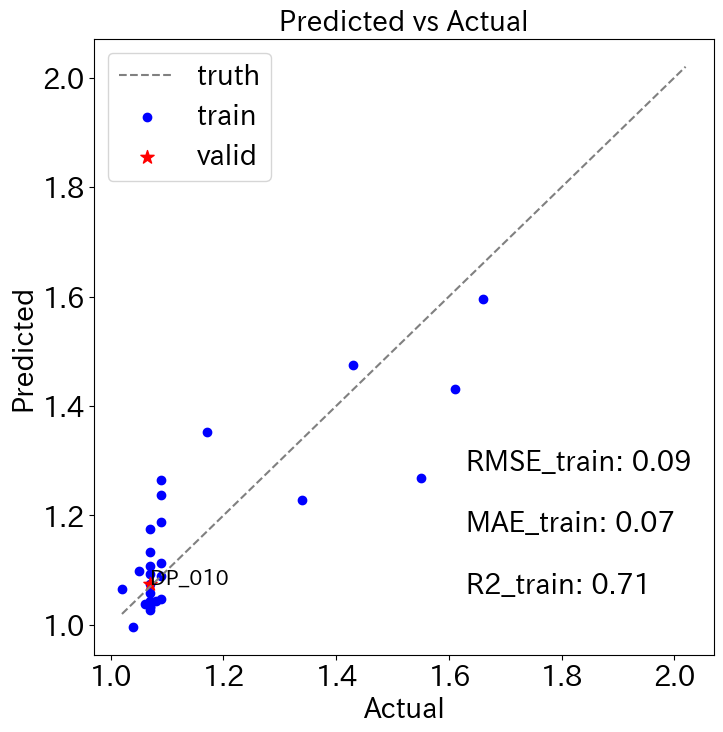

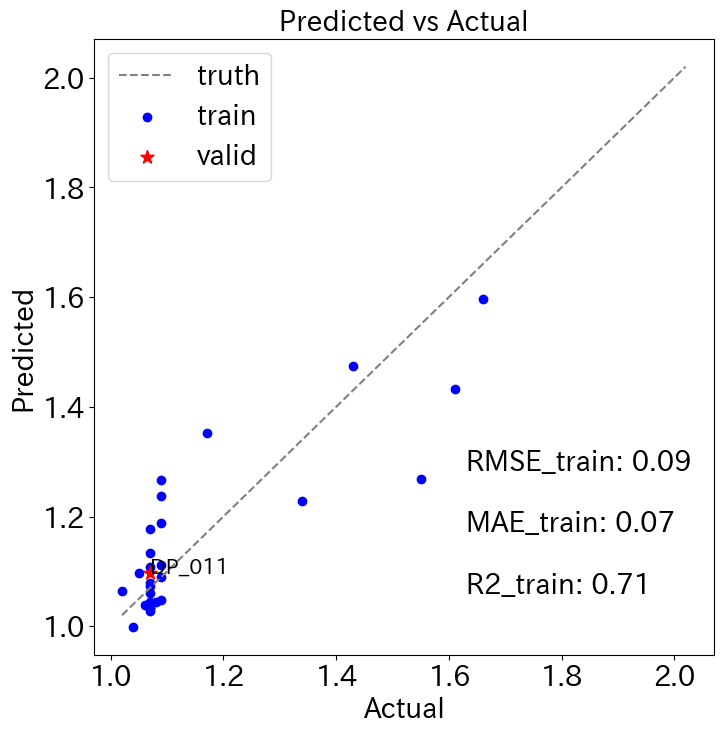

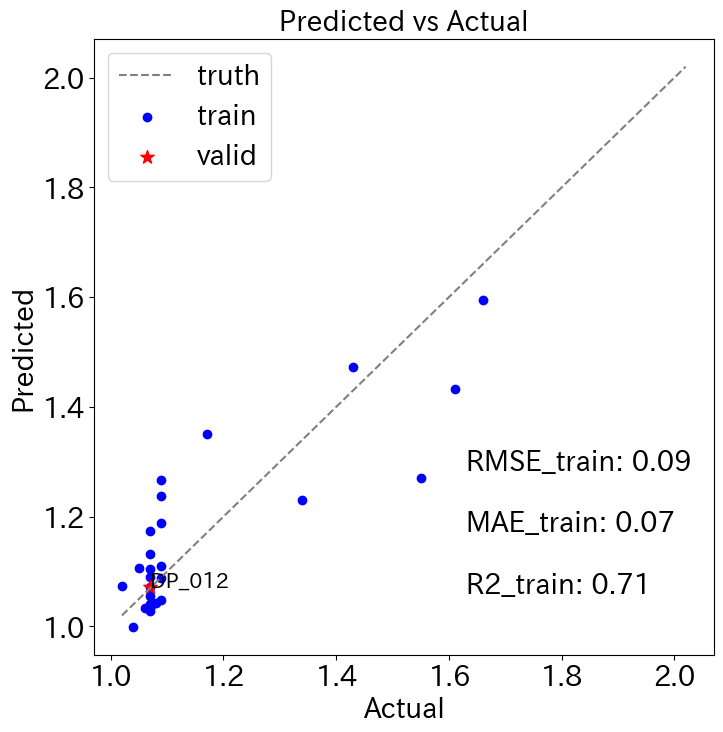

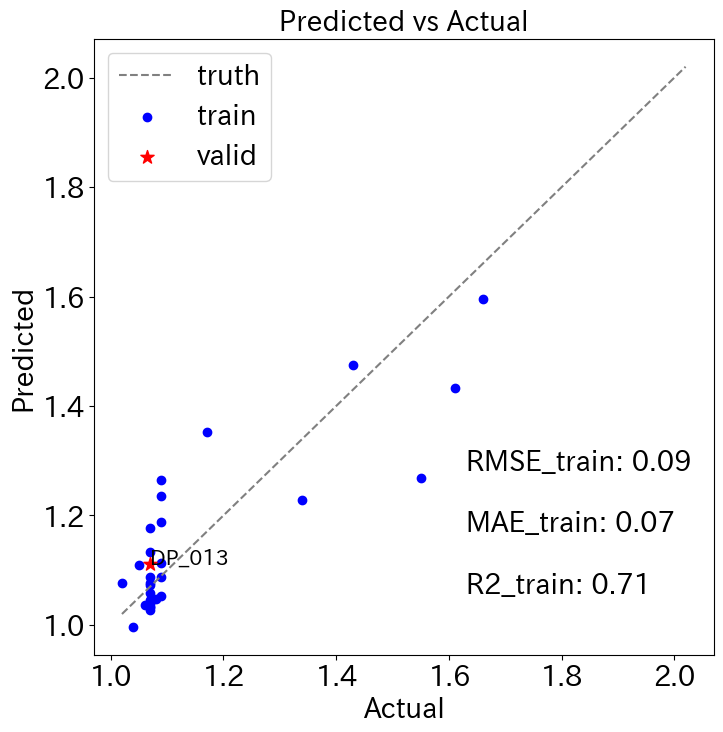

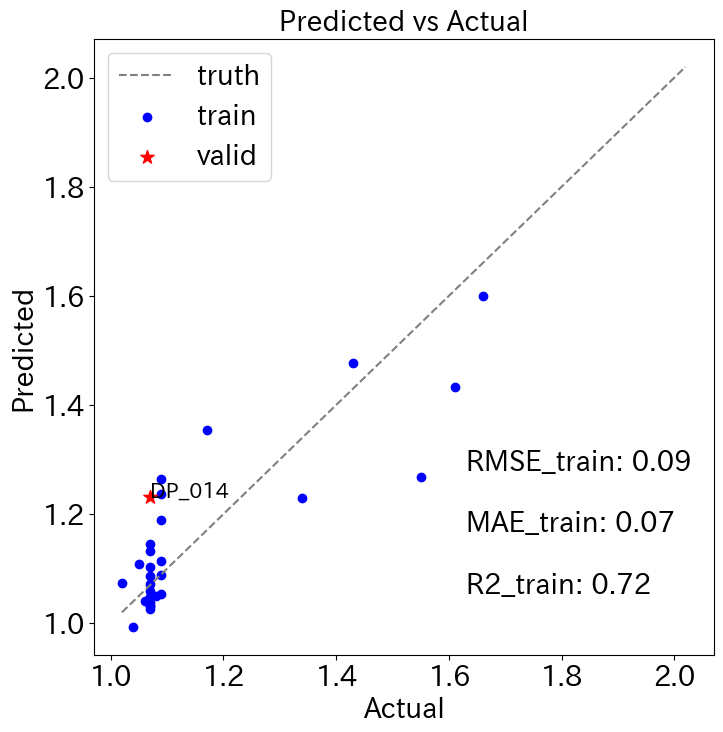

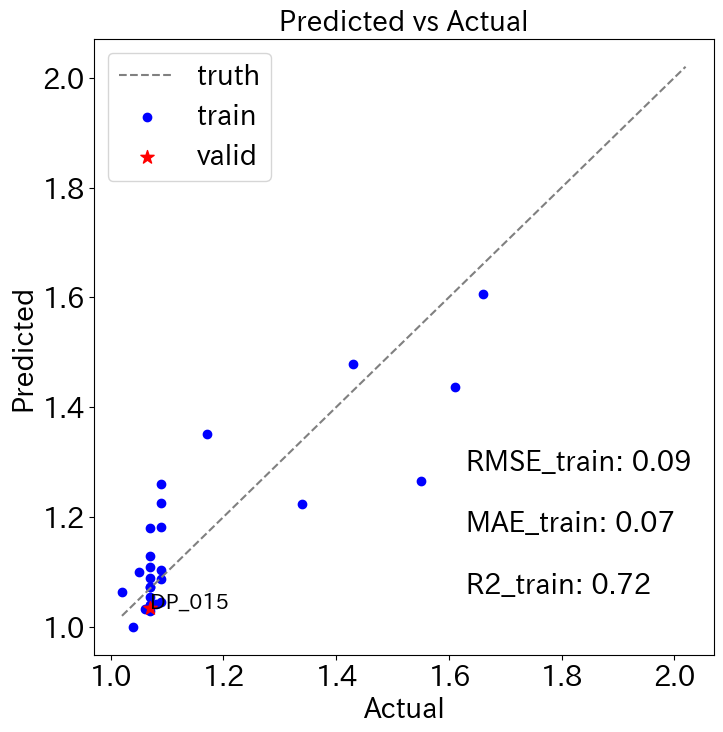

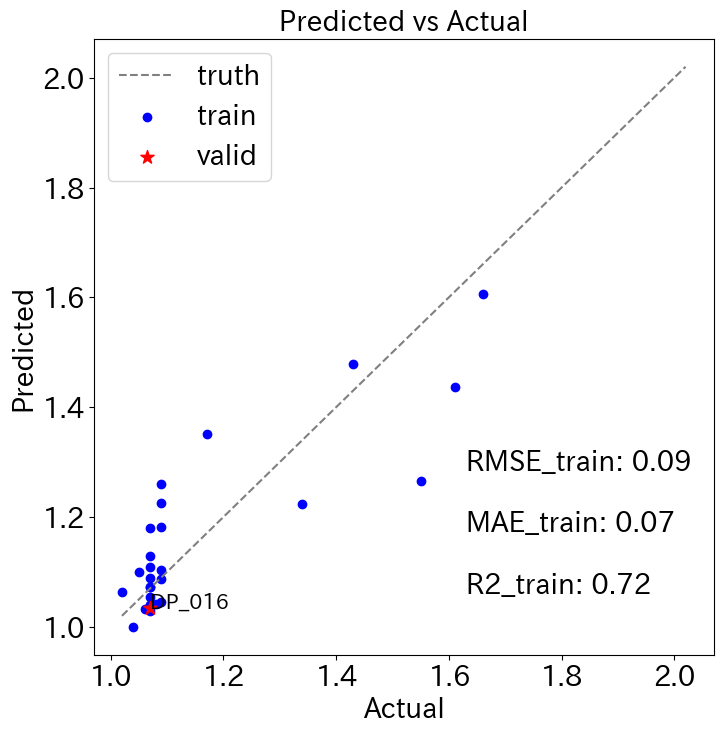

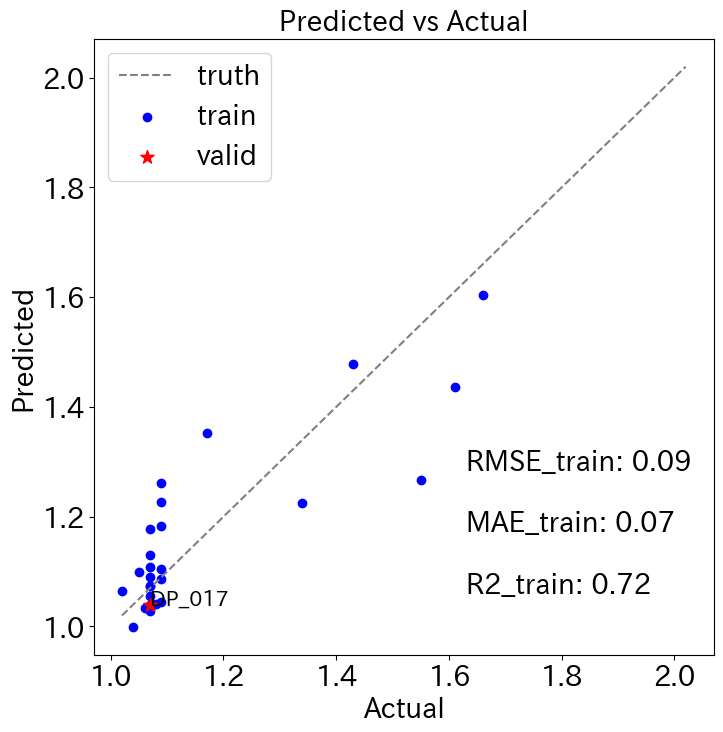

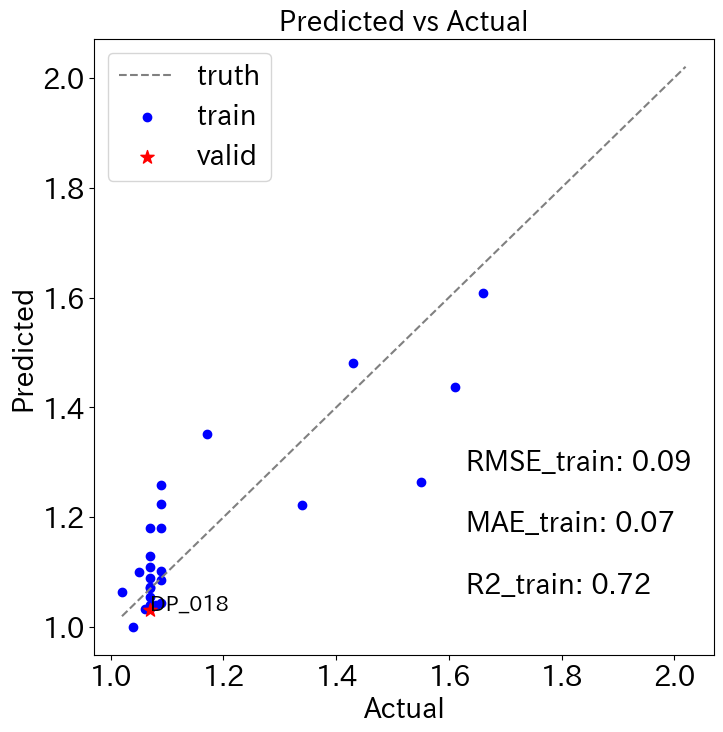

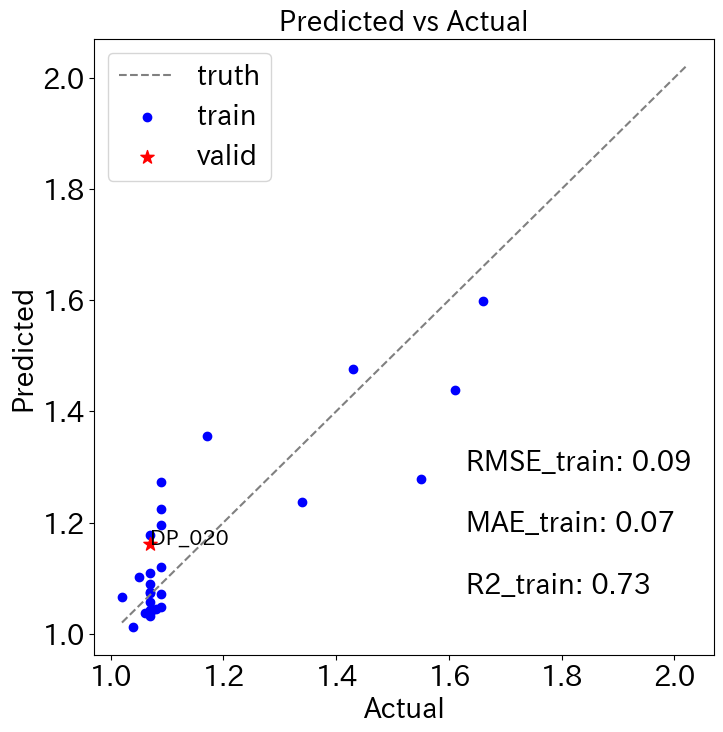

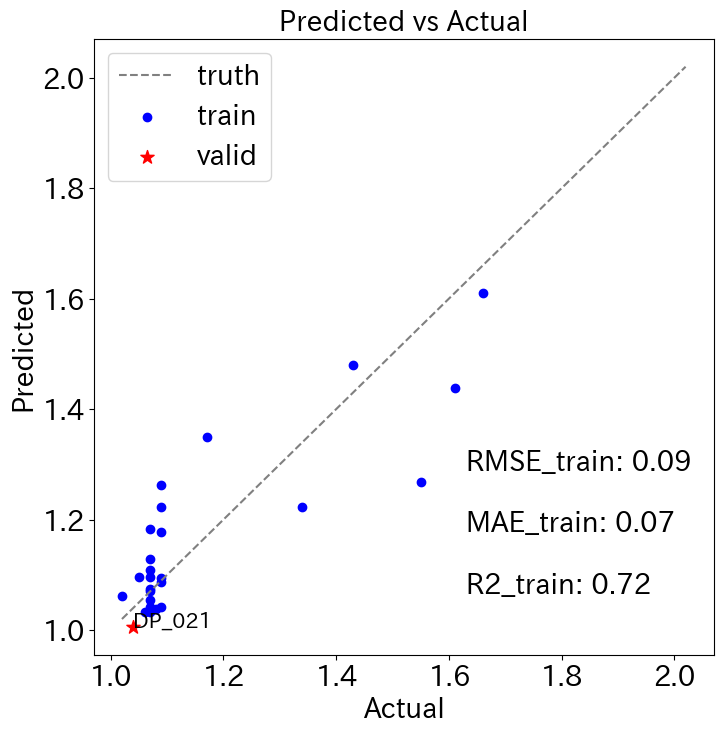

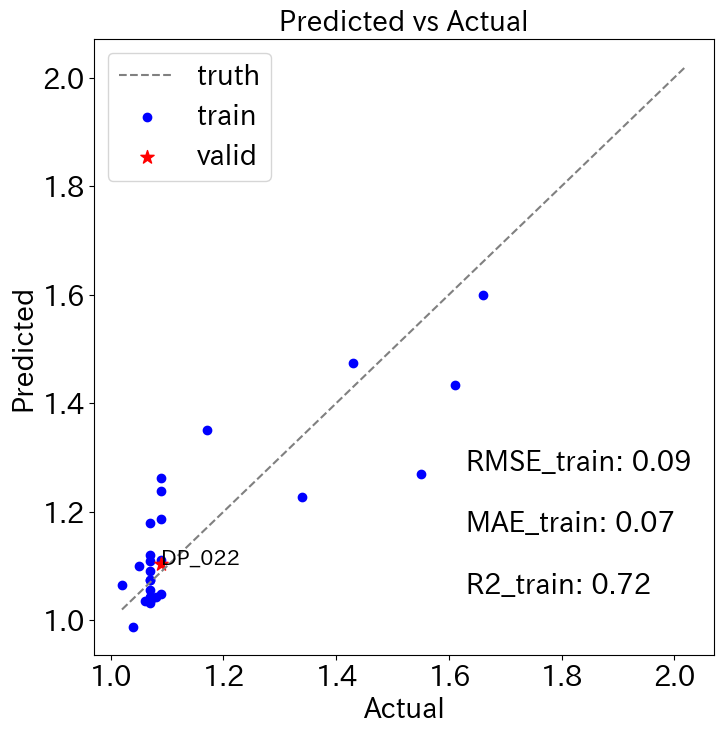

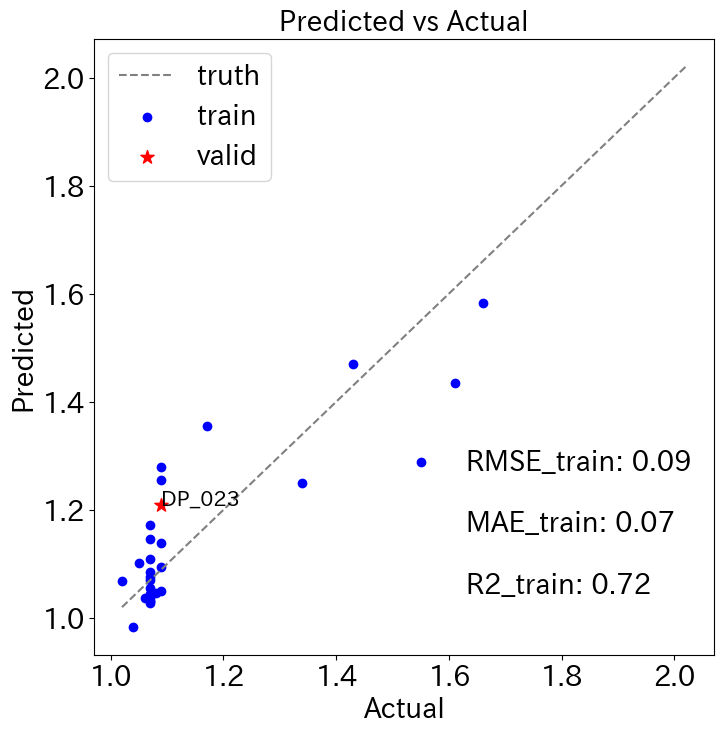

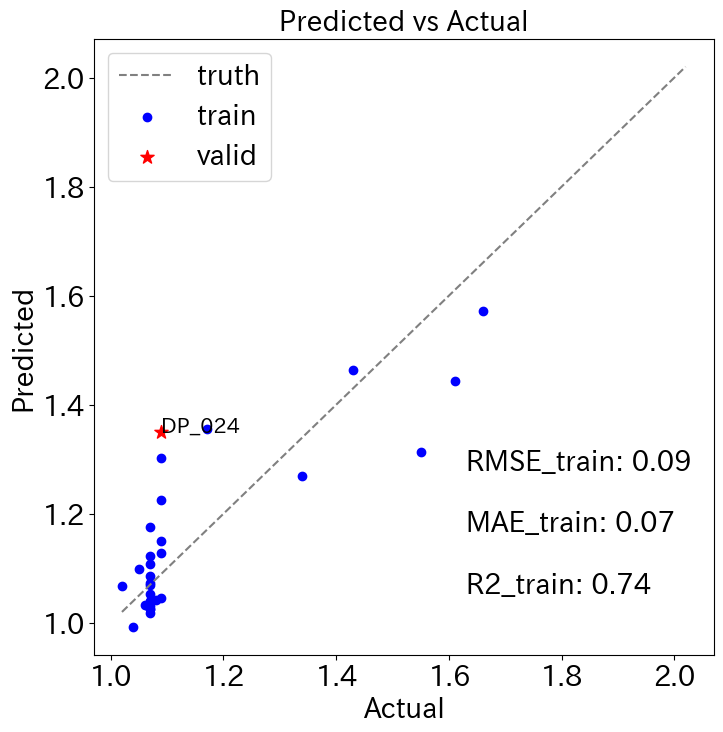

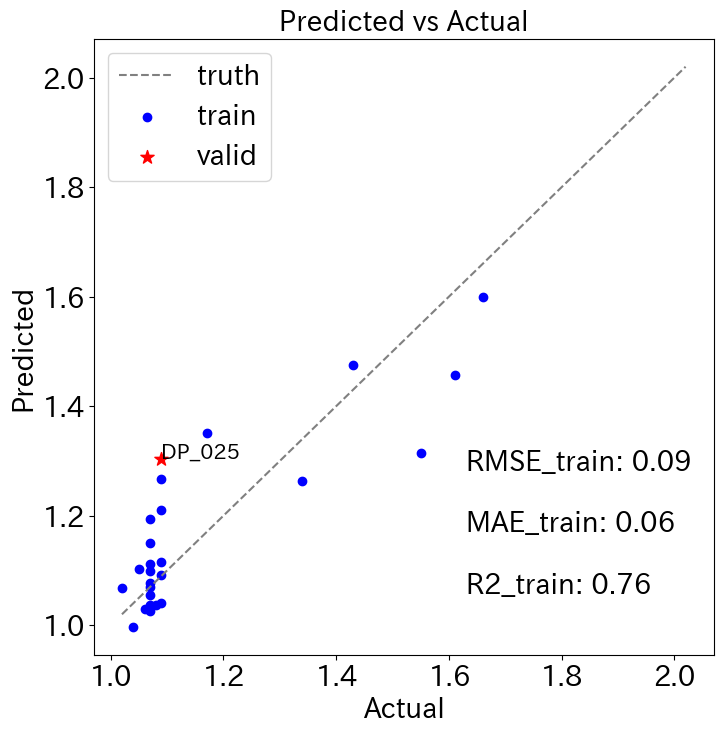

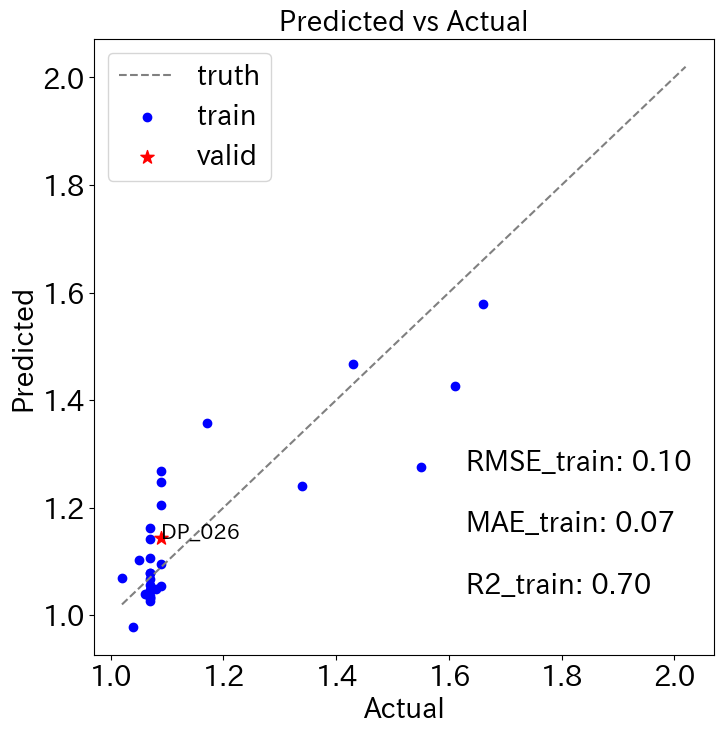

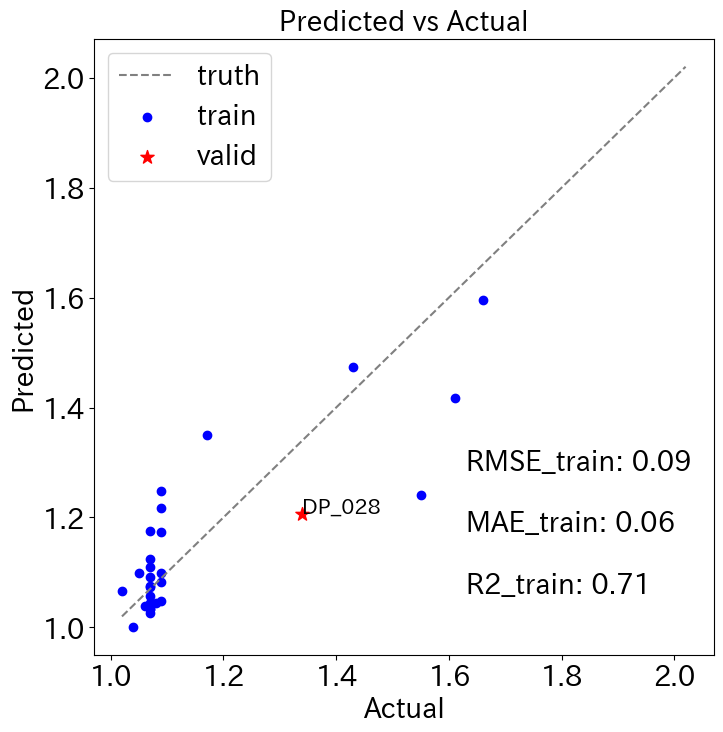

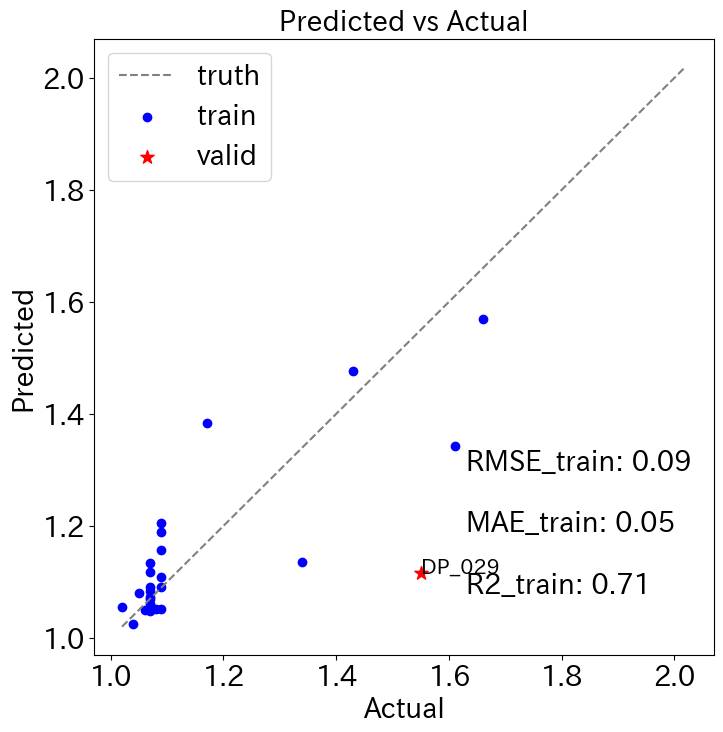

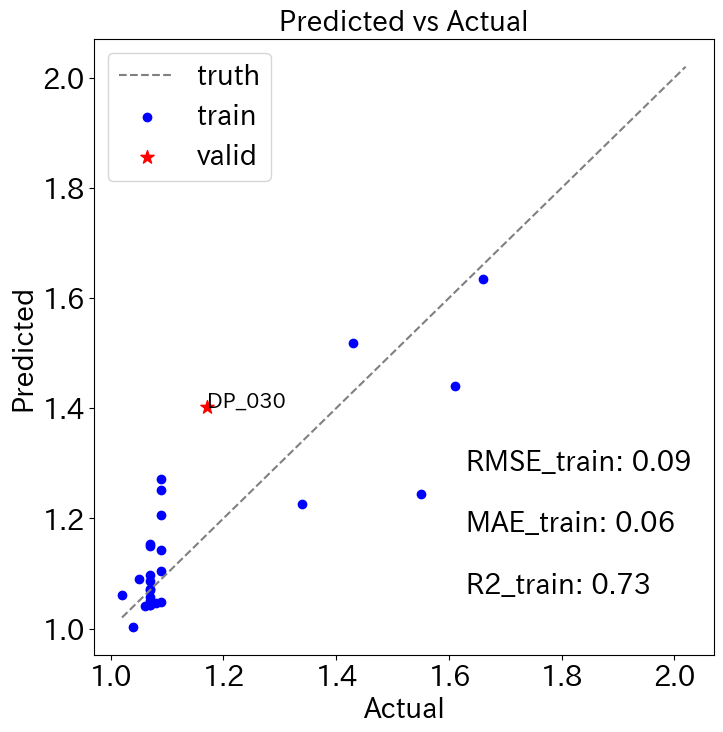

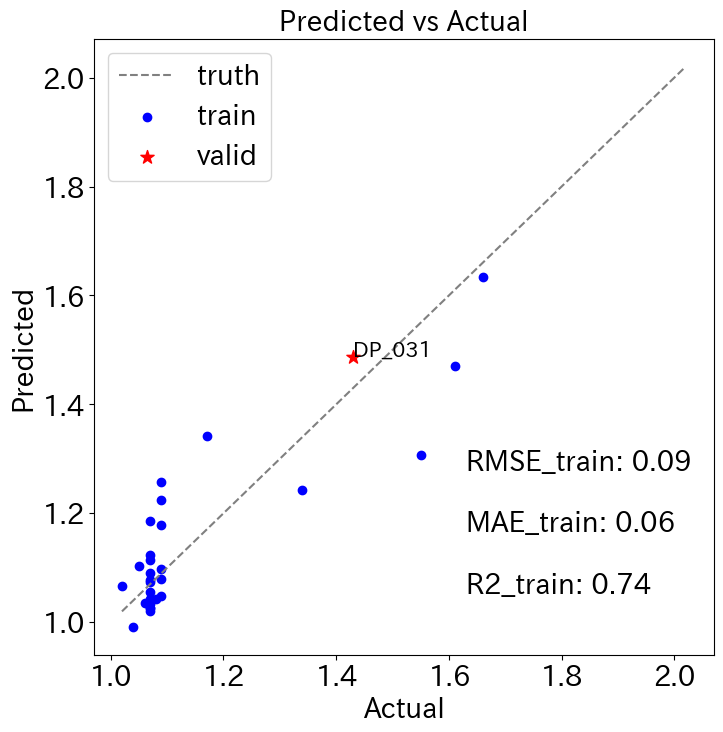

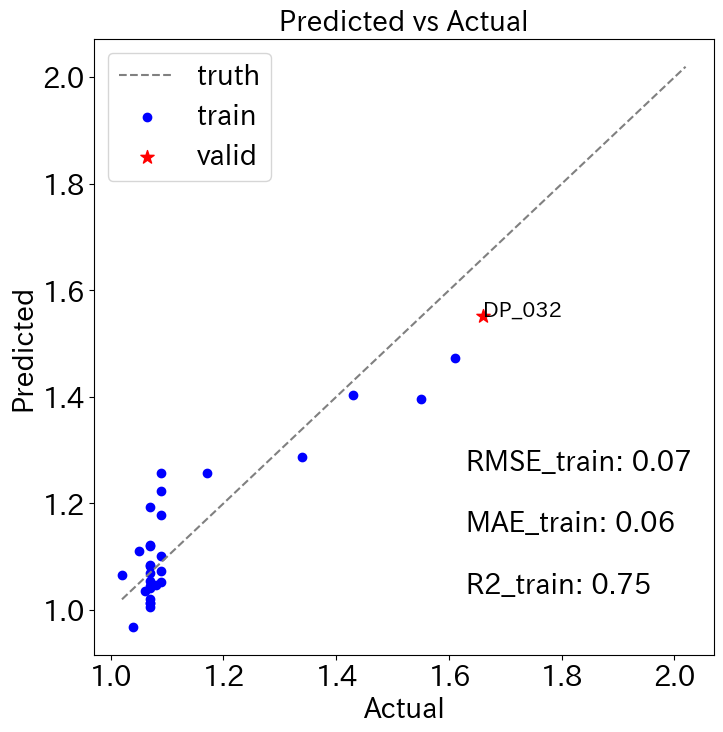

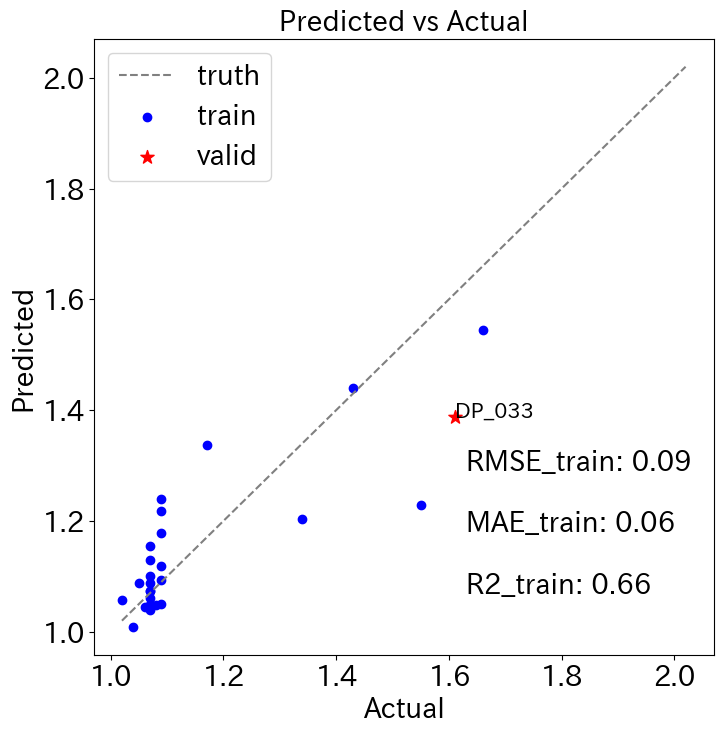

In [41]:
models = []
coef = []
rmses_train = []
maes_train = []
r2_train = []
rmses_valid = []
maes_valid = []
r2_valid = []
oof = np.zeros(len(train_X))

model = PLSRegression(n_components=2)

folds = len(train_X)
kf = KFold(n_splits=folds)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

for train_index, valid_index in tqdm(kf.split(train_X)):
    X_train = scaler_x.fit_transform(train_X.iloc[train_index])
    X_valid = scaler_x.transform(train_X.iloc[valid_index])
    y_train = scaler_y.fit_transform(train_Y.iloc[train_index].values.reshape(-1, 1))
    y_valid = scaler_y.transform(train_Y.iloc[valid_index].values.reshape(-1, 1))

    model.fit(X_train, y_train)
    y_pred_train = scaler_y.inverse_transform(model.predict(X_train).reshape(-1, 1))
    y_pred_valid = scaler_y.inverse_transform(model.predict(X_valid).reshape(-1, 1))

    y_train = scaler_y.inverse_transform(y_train)
    y_valid = scaler_y.inverse_transform(y_valid)

    tmp_rmses_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    tmp_maes_train = mean_absolute_error(y_train, y_pred_train)
    tmp_r2_train = r2_score(y_train, y_pred_train)

    tmp_rmses_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    tmp_maes_valid = mean_absolute_error(y_valid, y_pred_valid)
    tmp_r2_valid = r2_score(y_valid, y_pred_valid)

    print(train_Y.iloc[valid_index].index)
    print("RMSE_train:", tmp_rmses_train)
    print("MAE_train:", tmp_maes_train)
    print("R2_train:", tmp_r2_train)
    # print("RMSE_valid:", tmp_rmses_valid)
    # print("MAE_valid:", tmp_maes_valid)
    # print("R2_valid:", tmp_r2_valid)

    models.append(model)
    coef.append(model.coef_)
    rmses_train.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    maes_train.append(mean_absolute_error(y_train, y_pred_train))
    r2_train.append(r2_score(y_train, y_pred_train))
    # rmses_valid.append(np.sqrt(mean_squared_error(y_valid, y_pred_valid)))
    # maes_valid.append(mean_absolute_error(y_valid, y_pred_valid))
    # r2_valid.append(r2_score(y_valid, y_pred_valid))

    oof[valid_index] = y_pred_valid

    plt.figure(figsize=(8, 8))
    plt.title("Predicted vs Actual")
    plt.scatter(y_train, y_pred_train, label="train", color="blue")
    plt.scatter(y_valid, y_pred_valid, label="valid", color="red", marker="*", s=100)
    x_truth = np.arange(y_train.min(), y_train.max() + 1)
    y_truth = x_truth
    plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
    # plt.textでRMSE, MAE, R2を右下に表示
    plt.text(
        0.6, 0.3, f"RMSE_train: {tmp_rmses_train:.2f}", transform=plt.gca().transAxes
    )
    plt.text(
        0.6, 0.2, f"MAE_train: {tmp_maes_train:.2f}", transform=plt.gca().transAxes
    )
    plt.text(0.6, 0.1, f"R2_train: {tmp_r2_train:.2f}", transform=plt.gca().transAxes)
    # plt.txtでvalid_indexに対応するサンプルIDを表示
    for i, txt in enumerate(train_df.iloc[valid_index]["サンプルID"]):
        plt.text(y_valid[i], y_pred_valid[i], txt, fontsize=15)

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()

## Out-Of-Fold(OOF)のプロット

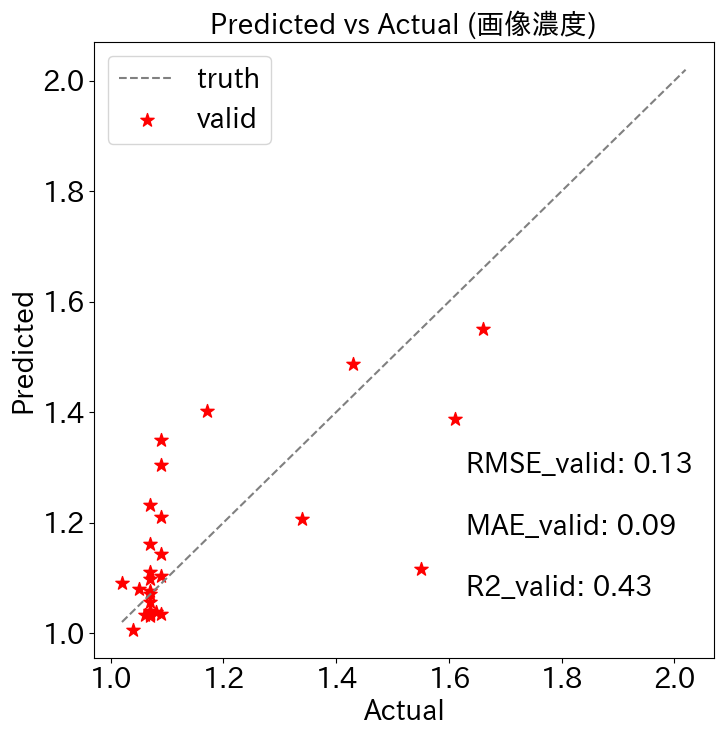

In [42]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title(f"Predicted vs Actual ({CFG.target})")
plt.scatter(train_Y, oof, label="valid", color="red", marker="*", s=100)
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() + 1)
y_truth = x_truth
plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(
    0.6,
    0.3,
    f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6,
    0.2,
    f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6, 0.1, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes
)
plt.legend()

## Out-Of-Fold(OOF)のプロット&各水準のIDを表示

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


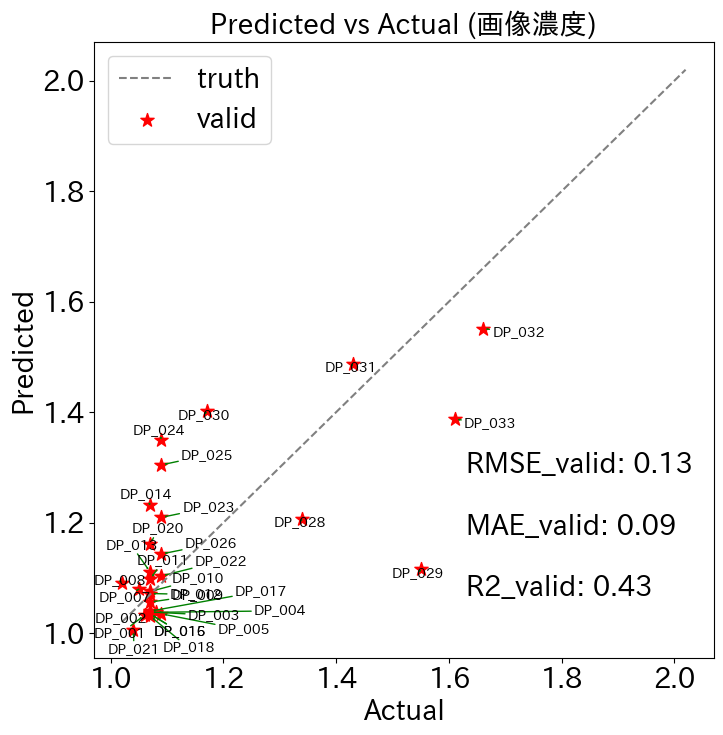

In [43]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title(f"Predicted vs Actual ({CFG.target})")
plt.scatter(train_Y, oof, label="valid", color="red", marker="*", s=100)
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() + 1)
y_truth = x_truth
plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(
    0.6,
    0.3,
    f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6,
    0.2,
    f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6, 0.1, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes
)
# plt.txtでvalid_indexに対応するサンプルIDを表示、adjustTextモジュールを使用して、重なりがないように表示
texts = [
    plt.text(train_Y.values[i], oof[i], train_df["サンプルID"][i], fontsize=10)
    for i in range(len(train_Y))
]
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="green"))
plt.legend()

## Leave-one-outにより得られた標準回帰係数の個数をカウント

In [44]:
len(coef)

30

## Leave-one-outによる各モデルの標準回帰係数の平均を算出

In [45]:
# 全てのモデルの係数の平均を算出
coef = np.array(coef)
coef = np.mean(coef, axis=0)
coef

array([[-0.26255464],
       [-0.14185063],
       [ 0.13803805],
       [-0.17713166],
       [ 0.014427  ],
       [-0.05452854],
       [ 0.02874465],
       [-0.0059895 ],
       [ 0.02790956],
       [ 0.50099359],
       [-0.0896198 ],
       [ 0.03950399],
       [ 0.        ],
       [ 0.        ],
       [-0.05708537],
       [-0.05794397]])

## 標準回帰係数の平均をデータフレームに格納

In [46]:
# coefをDataFrameに変換
coef_df = pd.DataFrame(coef, index=numeric_parameter_cols, columns=["coef"])
coef_df

,coef
溶媒１,-0.262555
溶媒2,-0.141851
溶媒3,0.138038
添加剤1,-0.177132
添加剤2,0.014427
界面活性剤１,-0.054529
界面活性剤２,0.028745
界面活性剤３,-0.005989
顔料１,0.027910
顔料２,0.500994


## 標準回帰係数の平均のデータフレームを絶対値の降順に並び替え

In [47]:
# coef_dfをcoefの絶対値の降順にソート
coef_df = coef_df.reindex(coef_df["coef"].abs().sort_values(ascending=False).index)
coef_df

,coef
顔料２,0.500994
溶媒１,-0.262555
添加剤1,-0.177132
溶媒2,-0.141851
溶媒3,0.138038
定着樹脂１,-0.089620
乾燥温度,-0.057944
乾燥方式,-0.057085
界面活性剤１,-0.054529
定着樹脂２,0.039504


## 標準回帰係数の平均をプロットして特徴量重要度として可視化

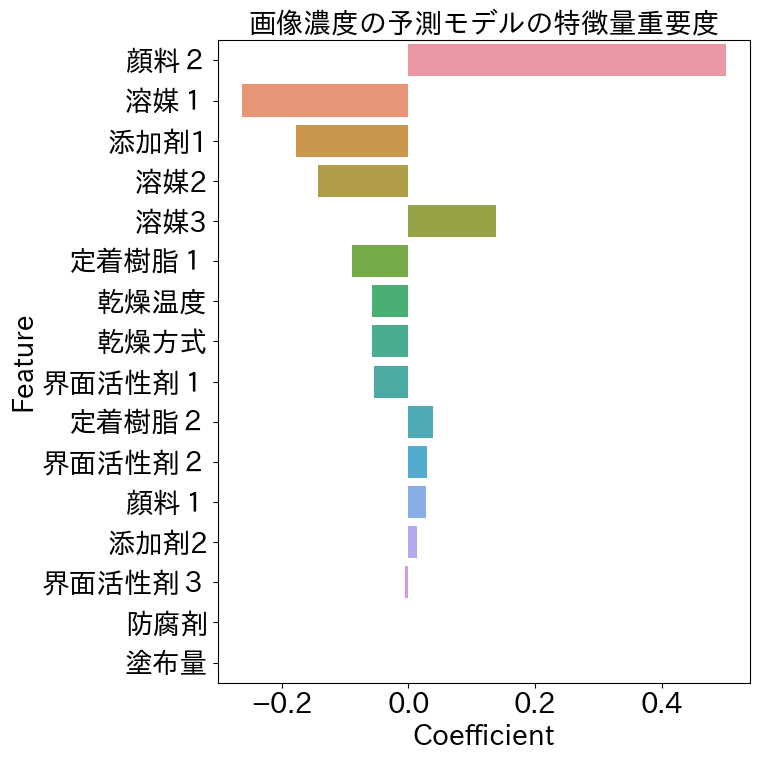

In [48]:
# coef_dfをsns.barplotで可視化
plt.figure(figsize=(8, 8))
sns.barplot(data=coef_df, x="coef", y=coef_df.index)
plt.title(f"{CFG.target}の予測モデルの特徴量重要度")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()

## テストデータを読み込み、データフレームに格納

In [49]:
test_df = pd.read_csv(f"{CFG.input_dir}/chapter2_demo_data_postprocess_test.csv")
test_df

,サンプルID,サンプル名,サンプル作成日,担当者,備考,溶媒１,溶媒2,溶媒3,添加剤1,添加剤2,...,乾燥温度,乾燥時間,擦過回数,擦過圧力,耐擦過性(n10,画像濃度,粘度,表面張力,保存後粘度,保存後状態
0,DP_0XX,test,NaN,NaN,NaN,42.9,0,40,0,2,...,100,0.03,10,5,5.0,1.47,8.0,38.0,9.8,正常


## テストデータについてLeave-one-outで得られた全てのモデルで予測して、その平均値をテストデータにおける予測値とする

In [50]:
# 全てのmodelで予測してその平均をとる
test_X = test_df[numeric_parameter_cols]
preds = []
for model in models:
    pred = scaler_y.inverse_transform(
        model.predict(scaler_x.transform(test_X)).reshape(-1, 1)
    )
    preds.append(pred)
preds = np.array(preds)
preds = preds.mean(axis=0)
preds

array([[1.38709881]])